In [1]:
#%load_ext autoreload

In [2]:
#%autoreload 2

In [3]:
#%pylab nbagg
#%pylab inline

<h1 align="center"><font size="16." face="arial" color="black">Tutorial TVB</font></h1>

<h1 align="center"> <font size="4.5" face="time roman">Giovanni Rabuffo - INS Marseille </font> </h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">In this tutorial we will:
<br>
<ul>
    <li> Build a first connectome-based simulation of brain activity </li> 
    <li> Simulate functional connectivity (FC) and its dynamics, as observed in empiric fMRI data</li>
</ul></font></div></p>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

<h1><font size="6" face="arial" color="#609BC4">Import</font></h1>

In [62]:
# Create environment ---> Install TVB ---> Within environment launch Jupiter lab and tutorial notebook

# INSTALL TVB @ ---> https://github.com/the-virtual-brain/tvb-root

In [13]:
%%capture
import numpy as np
import time as tm
import matplotlib.pyplot as plt   
from scipy import stats
from IPython.display import Image

#The Virtual Brain
import tvb
from tvb.simulator.lab import *

<h1><font size="6" face="arial" color="#609BC4">Overview</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<p><div style="text-align: justify"><font size="4.5" face="time roman">In TVB we look at the brain as a network. The brain is parceled into regions of interest (ROIs; network nodes) which are structurally connected with each other via white matter tracts ("structural" network links). </font>

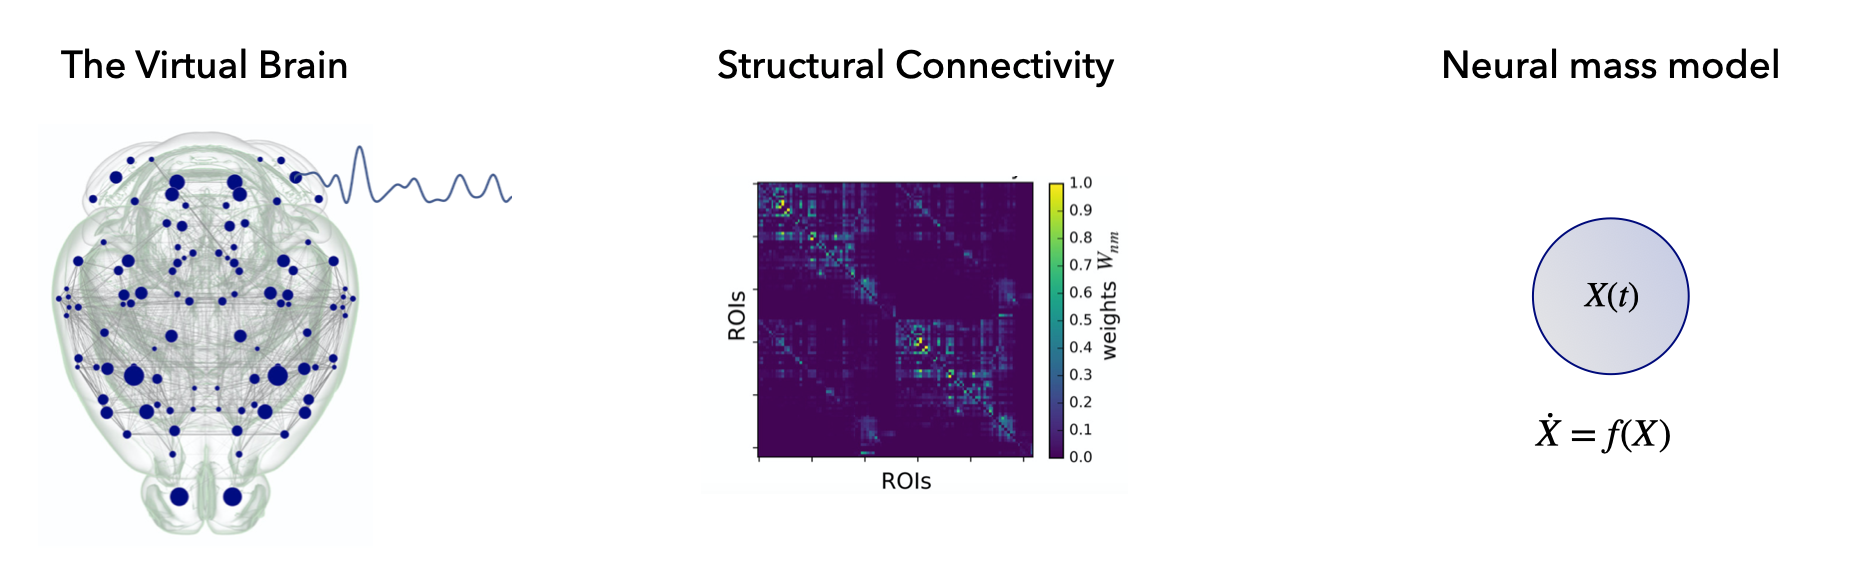

In [64]:
Image("Sources/BrainNet.png", width=1000, height=1000)

<p><div style="text-align: justify"><font size="4.5" face="time roman">The dynamics of one brain region is generally modeled by a set of differential equations describing the time evolution of a few variables (e.g., the mean membrane potential of a brain regions). </font>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A simulation of whole-brain dynamics is obtained by coupling many brain regions and solving the system of coupled differential equations. This solution can be compared to empiric data (LFP, BOLD,...). </font>

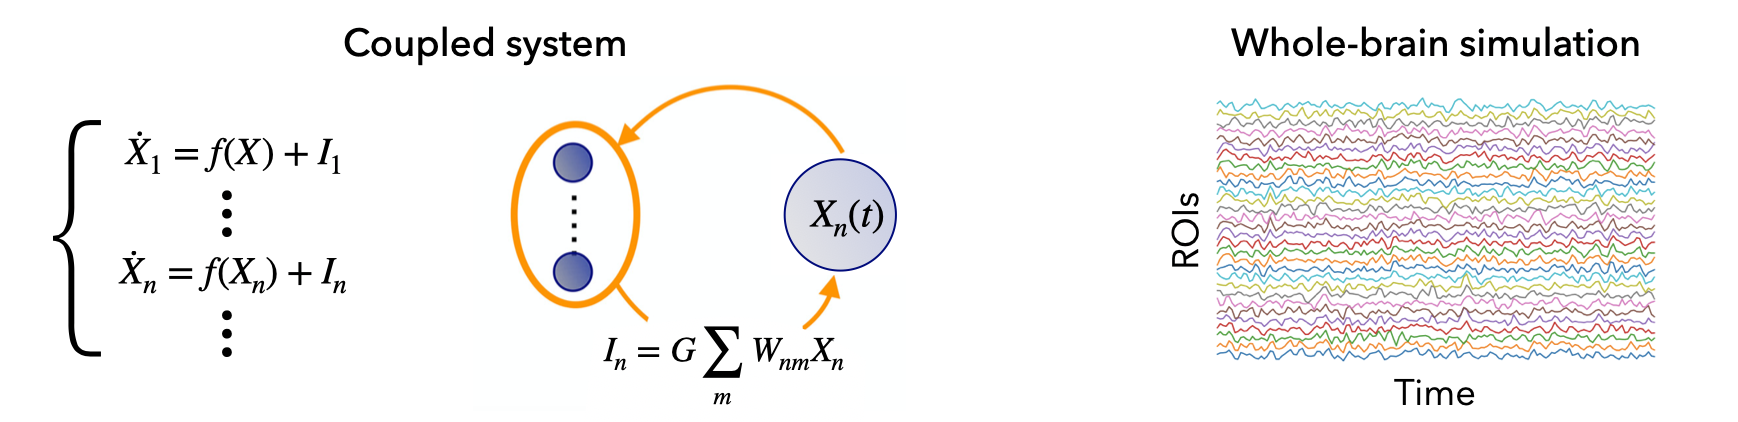

In [65]:
Image("Sources/Simulation.png", width=1000, height=1000)


***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<h1><font size="6" face="arial" color="black">TVB building blocks</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A basic TVB simulation consists of <b>5 main components</b>:
    <p><div style="text-align: justify"><font size="4.5" face="time roman">1) <b>Connectivity</b>: empiric structural connections between ROIs
    <p><div style="text-align: justify"><font size="4.5" face="time roman">2) <b>Model</b>: generally a set of nonlinear differential equations
    <p><div style="text-align: justify"><font size="4.5" face="time roman">3) <b>Coupling</b>: rule for coupling any pair of brain regions
    <p><div style="text-align: justify"><font size="4.5" face="time roman">4) <b>Integrator</b>: numerical algorithm used to run simulation
    <p><div style="text-align: justify"><font size="4.5" face="time roman">5) <b>Monitors</b>: output of simulator (simulated LFP, BOLD,...)


***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<h1><font size="6" face="arial" color="black">1) Connectivity</font></h1>
<p><div style="text-align: justify"><font size="4.5" face="time roman">It is generally imported from a .zip file containing the following infos:
    <p><div style="text-align: justify"><font size="4.5" face="time roman"> - <b>weights.txt</b>: N x N structural connectivity matrix
    <p><div style="text-align: justify"><font size="4.5" face="time roman"> - <b>centres.txt</b>: 3 x N matrix of (x,y,z) coordinates of each region
    <p><div style="text-align: justify"><font size="4.5" face="time roman"> - <b>tract_lengths.txt</b>: N x N matrix of distance between any pair of regions
    <p><div style="text-align: justify"><font size="4.5" face="time roman"> - <b>region_labels.txt</b>: N labels of the brain regions

In [31]:
# Import the anatomical structural connectivity
path='/Users/giovanni/Documents/GitHub/fufo/notebook/Tutorials/Raj_lab/Connectivity/'
Allen_SC = connectivity.Connectivity.from_file(path+'Allen_104.zip')

#set the conduction speed
Allen_SC.speed = np.asarray(np.inf)  

#Normalization
np.fill_diagonal(Allen_SC.weights, 0.)
Allen_SC.weights = Allen_SC.weights/np.max(Allen_SC.weights)

Allen_SC.configure()

# # ROIs Labels 
# with open(path+'Allen_104/region_labels.txt') as f:
#     content = f.readlines()   # remove whitespace characters like `\n` at the end of each line
# ROIs = [ix.strip() for ix in content] 

# #number of regions
# nregions = len(Allen_SC.weights)    

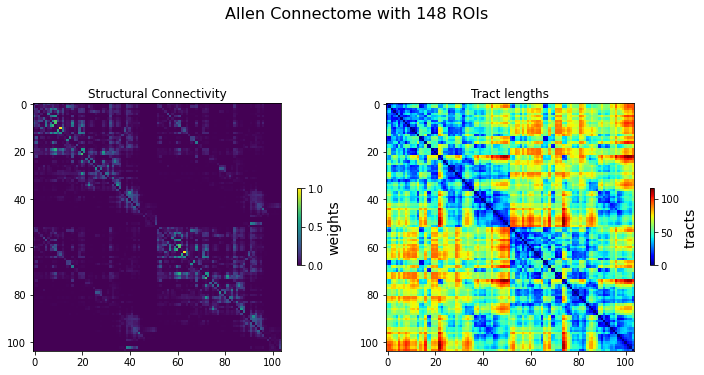

In [42]:
# Visualization
fig=plt.figure(figsize=(10,6));fig.suptitle('Allen Connectome with 148 ROIs', fontsize=16)

plt.subplot(121);plt.title('Structural Connectivity')
plt.imshow(Allen_SC.weights, interpolation='nearest', aspect='equal', cmap='viridis')
cb=plt.colorbar(shrink=0.2);cb.set_label('weights', fontsize=14)

plt.subplot(122);plt.title('Tract lengths')
plt.imshow(Allen_SC.tract_lengths, interpolation='nearest', aspect='equal', cmap='jet')
cb=plt.colorbar(shrink=0.2);cb.set_label('tracts', fontsize=14)

fig.tight_layout();plt.show()


***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<h1><font size="6" face="arial" color="black">2) Model</font></h1>
<p><div style="text-align: justify"><font size="4.5" face="time roman">There exist several models that one can chose in TVB 
<p><div style="text-align: justify"><font size="4.5" face="time roman">   -----> https://github.com/the-virtual-brain/tvb-root/tree/master/tvb_library/tvb/simulator/models
<p><div style="text-align: justify"><font size="4.5" face="time roman"> Here we import a simple nonlinear model by (Montbrio, Pazo, Roxin 2015) which has a number of interesting features:
<p><div style="text-align: justify"><font size="4.5" face="time roman"> - the MPR model describes the dynamics of the mean firing rate <b>r(t)</b> and mean membrane potential <b>V(t)</b> of a large population of quadratic integrate-and-fire (QIF) neurons. 
<p><div style="text-align: justify"><font size="4.5" face="time roman"> - the <b>local parameters</b> (i.e., of a single node) are: 1) the average excitability <b>\eta</b> of the QIF neurons; 2) The width of the excitability distribution <b>\Delta</b>; 3) The synaptic strength <b>J</b> across neurons. 4) a timescale <b>\tau</b> 
<p><div style="text-align: justify"><font size="4.5" face="time roman"> - When the local parameters are appropriately tuned, the model shows <b>bistability</b>: depending on the initial conditions, the variables end up in a DOWN stable state or they spiral into an UP stable state.
<p><div style="text-align: justify"><font size="4.5" face="time roman"> - A constant input current <b>I</b> causes a change in the size of the basins of attraction. In other words, as the current increases it is more probable to end up in the up state, rather than the down state.

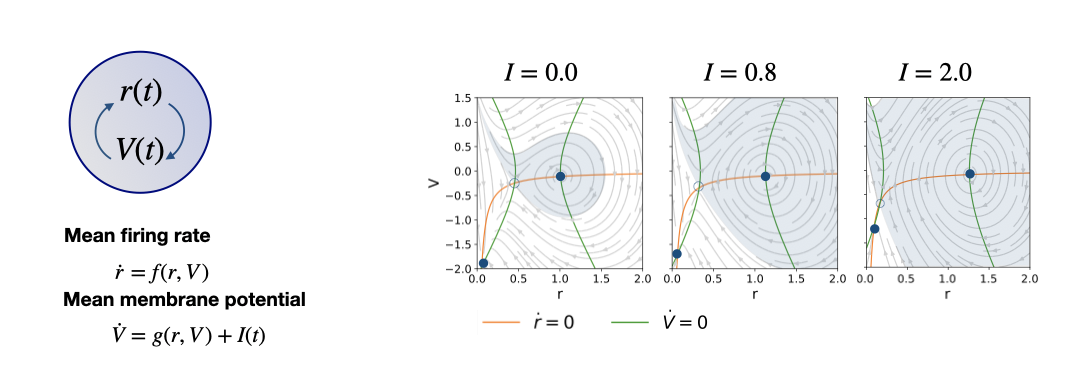

In [70]:
Image("Sources/MPR.png", width=1000, height=1000)

In [34]:
# Set local model parameters to a bistable regime
eta       =-4.6
Delta     =0.7
J         =14.5
tau       =1. 

# Import and configure model 
MPR = models.MontbrioPazoRoxin(
    J     = np.r_[J],
    eta     = np.r_[eta],
    Delta = np.r_[Delta],
    tau   = np.r_[tau],
)
MPR

,value
"Delta [min, median, max]","[0.7, 0.7, 0.7]"
Delta dtype,float64
Delta shape,"(1,)"
"Gamma [min, median, max]","[0, 0, 0]"
Gamma dtype,float64
Gamma shape,"(1,)"
"I [min, median, max]","[0, 0, 0]"
I dtype,float64
I shape,"(1,)"
"J [min, median, max]","[14.5, 14.5, 14.5]"



***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<h1><font size="6" face="arial" color="black">3) Coupling</font></h1>
<p><div style="text-align: justify"><font size="4.5" face="time roman">There exist several coupling rules that one can chose in TVB. Here we impose that the first variable of the source node n (firing rate r_n) enters additively into the equation of the second variable at the target node m (membrane potential V_m).

In [47]:
# Initialise a Coupling function.
G = 0.5     # GLOBAL COUPLING                  
con_coupling = coupling.Scaling(a=np.r_[G])

<p><div style="text-align: justify"><font size="4.5" face="time roman">The <b>global coupling G</b> sets the importance of the structural connectivity over the local dynamics. For G=0 the nodes are effectively decoupled and the local dynamics dominates the output of the simulation. The more G is increased, the more the structure impacts the dynamics. As we will see, this is a key parameter tu tune to get interesting system dynamics.


***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<h1><font size="6" face="arial" color="black">4) Integrator</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">TVB supports a number of schemes. For most purposes you can use either <b>HeunDeterministic</b> or <b>HeunStochastic</b>. 
<p><div style="text-align: justify"><font size="4.5" face="time roman">The second scheme adds a stochastic noise at each integration step, which results in noisy timeseries.

<p><div style="text-align: justify"><font size="4.5" face="time roman">Note that it  is important to use a step size that is small enough for the integration to be numerically stable. If the time step is too small the simulation could return trivial results of NaNs</font></div></p>

In [119]:
# Initialise an Integrator scheme.
dt = 0.01               #integration steps [ms]

heunint = integrators.HeunDeterministic(dt=dt)


#seed=42                 #different  seeds generate different random noise sequences
#nsigma = 0.0045         #standard deviation of the noise
#hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]),noise_seed=seed)
#heunint = integrators.HeunStochastic(dt=dt, noise=hiss)


***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<h1><font size="6" face="arial" color="black">5) Monitors</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> There are several Monitors in TVB. Some show the actual solution of the equations. Some others apply a biophysical filter to the simulated neural activity (EEG, BOLD,etc..). A few examples:
<pre></pre>

<ul>
<li>the <b>Raw</b> monitor takes no arguments and simply returns all the simulated data -- note: as a general rule, this monitor shouldn't be used for anything but very short simulations as the amount of data returned can become prohibitively large.</li>
</font></div></p>

<ul>
<li>the <b>TemporalAverage</b> monitor averages over a time window of length <i>period</i> returning one time point every <i>period</i> ms. </li>
</font></div></p>

<ul>
<li>the <b>Bold</b> takes as argument the BOLD period and returns the convolution of the raw data with the hemodynamic Kernel built in TVB.</li>
</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">  Here we will select the Temporal average (TAVG) monitor.

In [120]:
# Initialise some Monitors with period in physical time.

Tperiod   =10.
mon_tavg = monitors.TemporalAverage(period=1./Tperiod)       
# mon_raw = monitors.Raw()
# The BOLD monitor 
# mon_bold = monitors.Bold()

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

<h1 align="center"><font size="6"face="arial" color="black">Start First Basic Simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Let us bring all the above components together into a <b>Simulator</b> object.</font></div></p>

In [121]:
sim_len= 1000 #Time length in ms. The total number of time steps is sim_len/dt
#T_len=int(float(sim_len)/Tperiod) #
#T_len # number of time steps in the TimeAveraged monitor

In [122]:
# Initialise the Simulator.

sim = simulator.Simulator(
    model=MPR,
    connectivity=Allen_SC,
    coupling=con_coupling,
    conduction_speed=np.infty,
    integrator=heunint,
    monitors=[mon_tavg]
)

sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 26ecf228-0fee-443f-bacb-b419849c24af
coupling,Scaling gid: ac5f6aca-fcbc-4d33-8240-7d09388fbf95
gid,UUID('6e1003e3-20bb-4cc5-a80b-61a1ccdc3a45')
initial_conditions,None
integrator,HeunDeterministic gid: b65caa55-d689-4a15-b9ec-81dd70d0f819
model,MontbrioPazoRoxin gid: bbd9c03a-4272-46b3-9770-a55188d010e4
monitors,[]
simulation_length,1000.0


In [123]:
# Perform the simulation.

tic = tm.time()

(Tavg_time, Tavg_data), = sim.run(simulation_length=sim_len)

'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 59.613 seconds.'

In [124]:
# remove the first 
r      = Tavg_data[:,0,:,0]
V      = Tavg_data[:,1,:,0]     #Tavg_data[~Time,~Variable,~ROIs,0]
r.shape

(10000, 104)

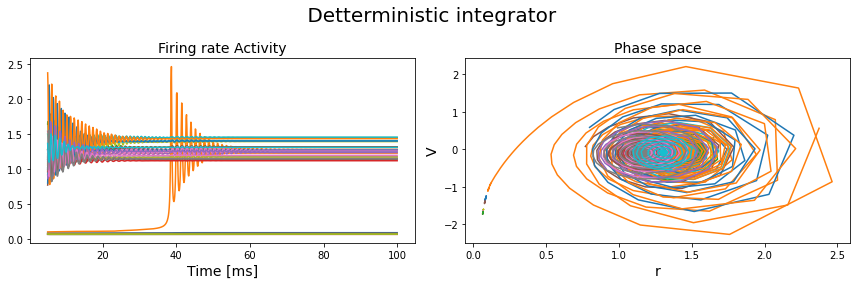

In [125]:
# Plot the raw time series 
fig = plt.figure(figsize=(12,4))
plt.suptitle(' Detterministic integrator', fontsize=20)
plt.subplot(121)
plt.plot(Tavg_time[50:1000], r[50:1000, :30])
plt.title('Firing rate Activity', fontsize=14)
plt.xlabel('Time [ms]', fontsize=14)

plt.subplot(122)
plt.plot(r[50:1000, :30], V[50:1000, :30])
plt.title('Phase space', fontsize=14)
plt.xlabel('r', fontsize=14);plt.ylabel('V', fontsize=14)

plt.tight_layout()

plt.show()

***

<h1 align="center"><font size="6"face="arial" color="black">Repeat with Stochastic integrator</font></h1>

In [133]:
# 1) Connectivity
path='/Users/giovanni/Documents/GitHub/fufo/notebook/Tutorials/Raj_lab/Connectivity/'
Allen_SC = connectivity.Connectivity.from_file(path+'Allen_104.zip')
Allen_SC.speed = np.asarray(np.inf)  
np.fill_diagonal(Allen_SC.weights, 0.)
Allen_SC.weights = Allen_SC.weights/np.max(Allen_SC.weights)
Allen_SC.configure()

# 2) Model
eta=-4.6; Delta=0.7;   J=14.5;  tau=1. 
MPR = models.MontbrioPazoRoxin(
    J     = np.r_[J],
    eta     = np.r_[eta],
    Delta = np.r_[Delta],
    tau   = np.r_[tau],
)

# 3) Coupling
G = 0.5               
con_coupling = coupling.Scaling(a=np.r_[G])

# 4) Integrator
dt = 0.01               #integration steps [ms]
seed=42                 #different  seeds generate different random noise sequences
nsigma = 0.01         #standard deviation of the noise
hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]),noise_seed=seed)
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

# 5) Monitors
Tperiod   =10.
mon_tavg = monitors.TemporalAverage(period=1./Tperiod)  

# Simulator
sim = simulator.Simulator(
    model=MPR,
    connectivity=Allen_SC,
    coupling=con_coupling,
    conduction_speed=np.infty,
    integrator=heunint,
    monitors=[mon_tavg]
)
sim.configure()

# Run
sim_len= 1000
tic = tm.time()
(Tavg_time, Tavg_data), = sim.run(simulation_length=sim_len)
'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 60.340 seconds.'

In [134]:
r_st      = Tavg_data[:,0,:,0]
V_st      = Tavg_data[:,1,:,0] 

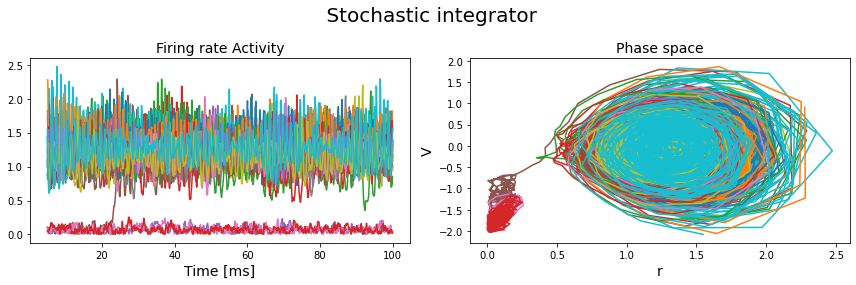

In [135]:
# Plot the raw time series 
fig = plt.figure(figsize=(12,4))
plt.suptitle(' Stochastic integrator', fontsize=20)
plt.subplot(121)
plt.plot(Tavg_time[50:1000], r_st[50:1000, :30])
plt.title('Firing rate Activity', fontsize=14)
plt.xlabel('Time [ms]', fontsize=14)

plt.subplot(122)
plt.plot(r_st[50:1000, :30], V_st[50:1000, :30])
plt.title('Phase space', fontsize=14)
plt.xlabel('r', fontsize=14);plt.ylabel('V', fontsize=14)

plt.tight_layout()

plt.show()

***

***

***

<h1 align="center"><font size="6"face="arial" color="black"> Resting State Network Dynamics</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

<p><div style="text-align: justify"><font size="4.5" face="time roman">Say that we are analyzing a resting-state fMRI dataset and we want to characterize the correlation patterns and the dynamics of the resting-state networks. </font>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> A convenient way of doing so is by focusing on "Edge co-activations". Given any two nodes with z-scored BOLD time series <b>X_n(t)</b> and <b>X_m(t)</b>, the respective edge co-activation time series of edge <b>E_nm(t)</b> is defined as their element-wise product. Its time-average returns the Pearson correlation between <b>X_n(t)</b> and <b>X_m(t)</b> </font>

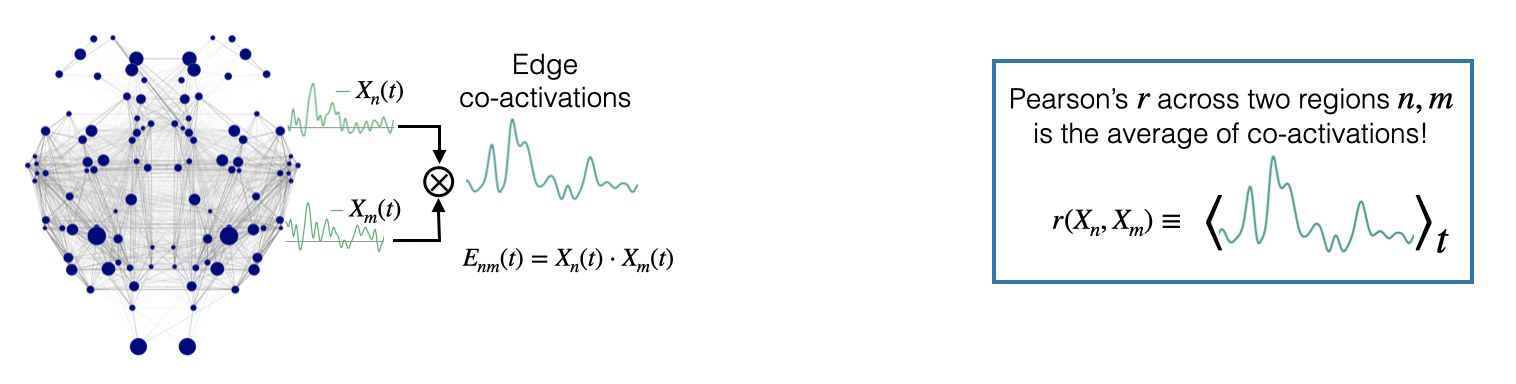

In [131]:
Image("Sources/Edges.png", width=1000, height=1000)

<p><div style="text-align: justify"><font size="4.5" face="time roman"> Looking at the dynamics of all the network edges in empiric  datasets, one notices that strong co-activations occurr suddenly across the whole network, and these network-wide co-activation bursts are short-lived and aperiodic.

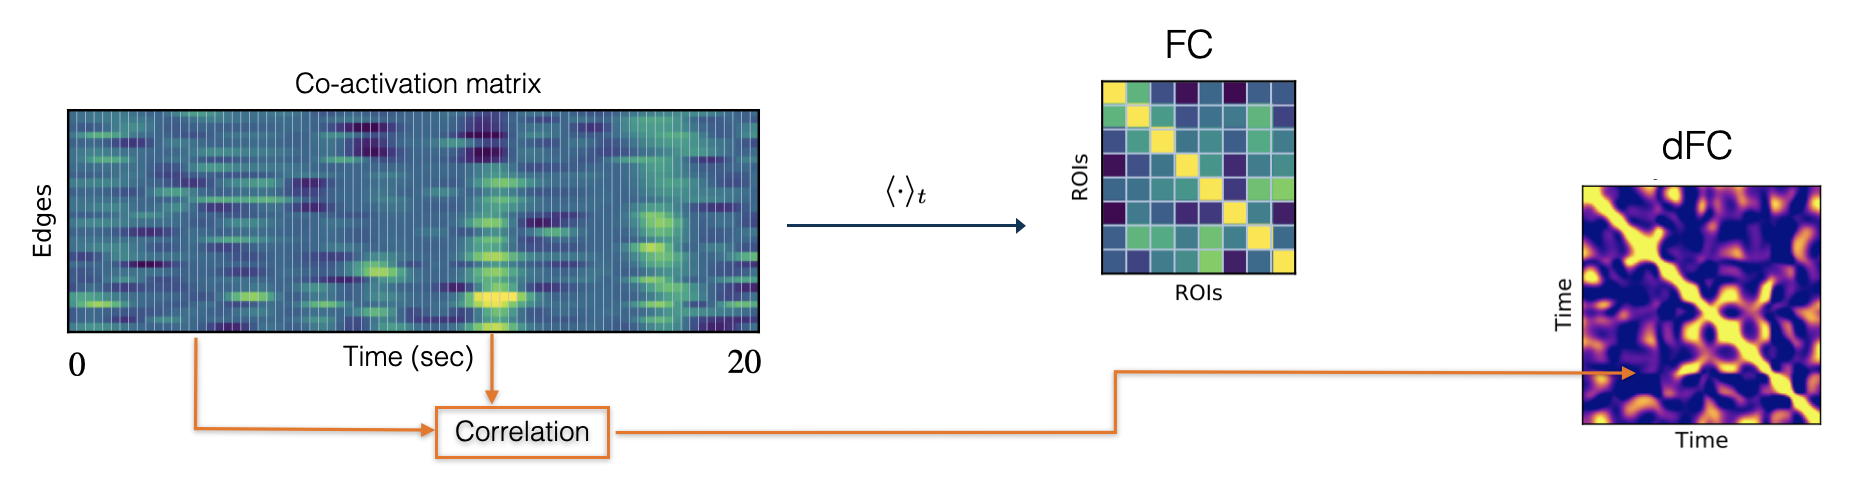

In [132]:
Image("Sources/FC.png", width=1000, height=1000)

<p><div style="text-align: justify"><font size="4.5" face="time roman"> This edge perspective is interesting because simple and gives an intuitive understanding of resting-state network dynamics:
<p><div style="text-align: justify"><font size="4.5" face="time roman">  - averaging across time, we obtain the Pearson Correlation for all the edges i.e., the Functional Connectivity. By visual inspection it is clear that the co-activation bursts contribute the most to this average.
<p><div style="text-align: justify"><font size="4.5" face="time roman">  - We can also define the Functional Connectivity dynamics without the use of sliding windows, by correlating co-activation patterns at different times.

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

<p><div style="text-align: justify"><font size="4.5" face="time roman">  <b>Looking at only 5% of timepoints corresponding to the strongest bursts one can recover FC and dFC !</b>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> - These bursts are observed across species and across modalities (EEG, SEEG, MEG, fMRI..)
<p><div style="text-align: justify"><font size="4.5" face="time roman"> - a typical artifact (e.g., movement) it is gonna look like a burst
<p><div style="text-align: justify"><font size="4.5" face="time roman"> - if the bursts are artifacts, move to thrash the past decades of RSN analyses?

<p><div style="text-align: justify"><font size="4.5" face="time roman">   <b>We can use connectome-based simulations to show that bursts can spontaneously emerge in connected networks! </b>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

<h1 align="center"><font size="6"face="arial" color="black"> Simulate fMRI Functional Connectivity and edge co-activation bursts</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> Changing the global coupling G we can explore different regimes of activity. We will show here a simulation performed in an interesting working regime. Note: the simulation requires several minutes! </font>

In [148]:
# 1) Connectivity
path='/Users/giovanni/Documents/GitHub/fufo/notebook/Tutorials/Raj_lab/Connectivity/'
Allen_SC = connectivity.Connectivity.from_file(path+'Allen_104.zip')
Allen_SC.speed = np.asarray(np.inf)  
np.fill_diagonal(Allen_SC.weights, 0.)
Allen_SC.weights = Allen_SC.weights/np.max(Allen_SC.weights)
Allen_SC.configure()

# 2) Model
eta=-4.6; Delta=0.7;   J=14.5;  tau=1. 
MPR = models.MontbrioPazoRoxin(
    J     = np.r_[J],
    eta     = np.r_[eta],
    Delta = np.r_[Delta],
    tau   = np.r_[tau],
)

# 3) Coupling
G = 0.45               
con_coupling = coupling.Scaling(a=np.r_[G])

# 4) Integrator
dt = 0.025               #integration steps [ms]
seed=42                 #different  seeds generate different random noise sequences
nsigma = 0.01         #standard deviation of the noise
hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]),noise_seed=seed)
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

# 5) Monitors
Bperiod   =2000.
mon_bold = monitors.Bold(period=Bperiod)

# Simulator
sim = simulator.Simulator(
    model=MPR,
    connectivity=Allen_SC,
    coupling=con_coupling,
    conduction_speed=np.infty,
    integrator=heunint,
    monitors=[mon_bold]
)
sim.configure()

# Run
sim_len= 200e3
tic = tm.time()
(Bold_time, Bold_data), = sim.run(simulation_length=sim_len)
'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 2306.304 seconds.'

In [149]:
np.savez('Bold_data_tutorial',Bold_data)

In [175]:
Bold = Bold_data[20:,1,:,0] 

In [176]:
# FC as Pearson Correlation matrix
FC=np.corrcoef(Bold.T)

In [177]:
def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1) 
    gz=stats.zscore(tseries)
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

#Edge co-activations
Edge_CA=go_edge(Bold)

#Functional Connectivity Dynamics
dFC=np.corrcoef(Edge_CA)

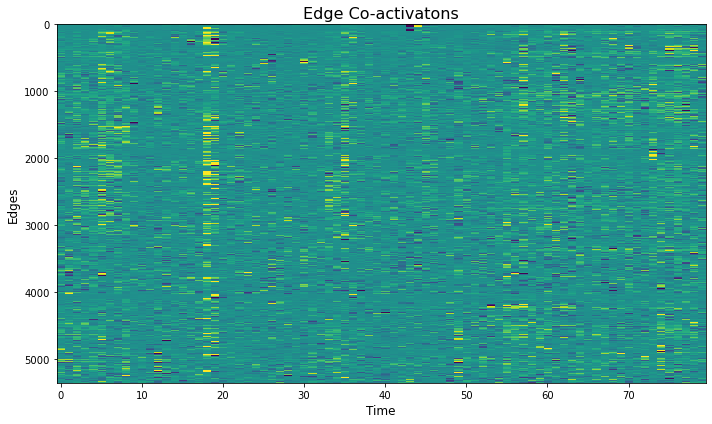

In [178]:
# Visualization
fig=plt.figure(figsize=(10,6));plt.title('Edge Co-activatons', fontsize=16)
plt.imshow(Edge_CA.T, interpolation='nearest', aspect='auto', cmap='viridis',vmin=-5,vmax=5)
plt.xlabel('Time', fontsize=12);plt.ylabel('Edges', fontsize=12)
fig.tight_layout();plt.show()

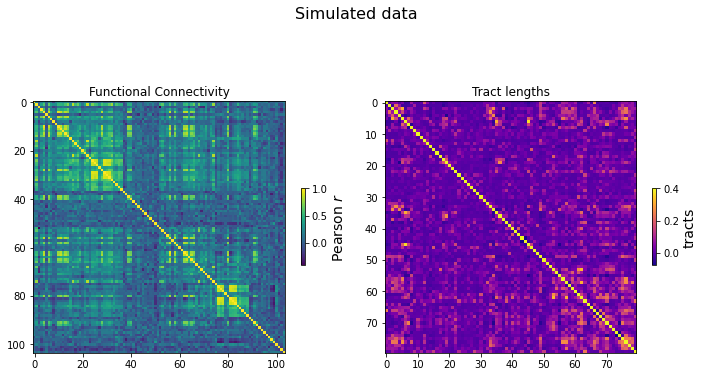

In [180]:
# Visualization
fig=plt.figure(figsize=(10,6));fig.suptitle('Simulated data', fontsize=16)

plt.subplot(121);plt.title('Functional Connectivity')
plt.imshow(FC, interpolation='nearest', aspect='equal', cmap='viridis')
cb=plt.colorbar(shrink=0.2);cb.set_label('Pearson $r$', fontsize=14)

plt.subplot(122);plt.title('Tract lengths')
plt.imshow(dFC, interpolation='nearest', aspect='equal', cmap='plasma',vmax=0.4)
cb=plt.colorbar(shrink=0.2);cb.set_label('tracts', fontsize=14)

fig.tight_layout();plt.show()

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

<h1 align="center"><font size="6"face="arial" color="black"> References </font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> Rabuffo, Fousek, Bernard, Jirsa, eNeuro 2021 -----> https://www.eneuro.org/content/8/5/ENEURO.0283-21.2021 </font>